In [0]:
!pip install torchvision

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [0]:
# Import packages
import torch
import torch.nn as nn
import os
import numpy as np
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import save_image
from PIL import Image
from torch.autograd import Variable
import matplotlib.pyplot as plt
from ipywidgets import interactive

In [0]:
# Constant
dim_im = 28 # Image Dimension
channel_im = 1 # Image Channel
epo = 30 # Number of epochs
l_step = 10 # Number of Langevin Steps
lr = 0.001 # Learning Rate
dim_z = 8 # Laten Variable Dimension
hidden_size = 400 # Size of hidden variables
sigma = 0.3 # Noise Variance
lang_sigma = 0.05 # Langevin Step Size
batch_size = 32 # Batch Size
s1 = 1 # First Gaussin Distribution Variance
s2 = 0.1 # Second Gaussian Distribution Variance
alpha = 0.01 # Spike Variable

In [0]:
# Define generator model
class generator(nn.Module):
    def __init__(self):
        super().__init__()     
        
        self.to_feature = nn.Sequential( # Input Latent Variable Z to Features 
        
            nn.Linear(dim_z, hidden_size),
            nn.ReLU(),

            nn.Linear(hidden_size, 7*7*64),
            nn.ReLU()

        )

        self.model = nn.Sequential( # Input Features:7x7x64
            
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False), # Output 14x14x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False), # Output 28x28x1
            nn.Sigmoid()

        )

    def forward(self, z):
        out = self.to_feature(z)
        out = out.view(z.shape[0], 64, 7, 7)
        out = self.model(out)
        out = out.view(z.shape[0], channel_im, dim_im, dim_im)
        return out

In [0]:
# Initialize weight 
def init_weight(m):
    classname = m.__class__.__name__
    if classname.find("ConvTranspose2d") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.001)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.001)
        nn.init.normal_(m.bias.data, 0.0)

In [0]:
# Loss function
def loss_function(actual, pred, sigma, s1, s2, alpha, z):
    loss = 0.5 / (sigma ** 2) * torch.pow(actual - pred, 2).sum()
    return loss

In [0]:
# Derivative of Z
def der_z(z, s1, s2, alpha):
  grad = -(alpha * z / (s1 ** 3) * torch.exp(-torch.pow(z, 2) / 2 / (s1 ** 2)) + (1 - alpha) * z / (s2 ** 3) * torch.exp(-torch.pow(z, 2) / 2 / (s2 ** 2))) / (alpha / s1 * torch.exp(-torch.pow(z, 2) / 2 / (s1 ** 2)) + (1 - alpha) / s2 * torch.exp(-torch.pow(z, 2) / 2 / (s2 ** 2)))
  return grad

In [0]:
def plot_latent(image, z):
  fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
  img = torchvision.utils.make_grid(image.cpu()).detach().numpy()
  ax0.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
  ax0.set_title('Input Image', fontsize=20)
    
  ax1.bar(np.arange(z.shape[1]), height=z.cpu().detach().numpy()[0], width=1/7, align='center')
  ax1.stem(np.arange(z.shape[1]), z.cpu().detach().numpy()[0], markerfmt=' ', use_line_collection=True)
  ax1.axhline(y=0)
  ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % (z.shape[1], alpha), fontsize=20)
    
  img = g(z)
  img = torchvision.utils.make_grid(img.view(1,channel_im,dim_im,dim_im)).cpu().detach().numpy()
  ax2.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
  ax2.set_title('Decoded Image', fontsize=20)
  plt.subplots_adjust(hspace=0.5)
  plt.savefig('sc_result.png')
  print('Result Image Saved!')

In [8]:
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [9]:
# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
# Initialize generator and weights
g = generator()
g.apply(init_weight)
g.to(device) # Model To GPU
opt_g = torch.optim.Adam(g.parameters(), lr=lr) # Initizlie Adam optimizer

In [0]:
z = alpha * Variable(torch.randn(60000, dim_z)) + (1 - alpha) * Variable(torch.randn(60000, dim_z).mul_(s2)) # Sample latent variable Z
z = z.cuda().requires_grad_() # To GPU and gradient will be calculated

Iteration: 0
Loss: 6781566.873291016
Z sum:  tensor(74677.7734, device='cuda:0')


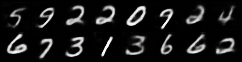

Result Image Saved!


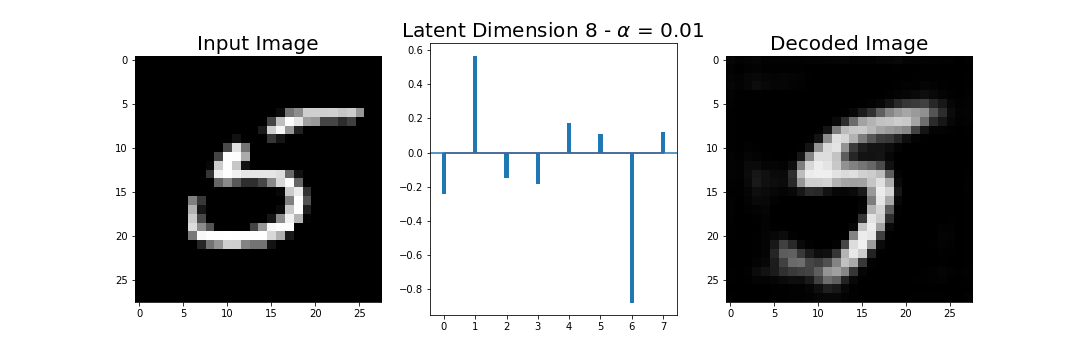

Spike and Slab Prior
Save image


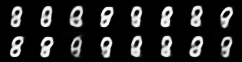

Gaussian Prior
Save image


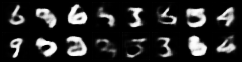

Iteration:  1
Loss 4863021.8017578125
Z sum:  tensor(113798.2734, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  2
Loss 4396349.136108398
Z sum:  tensor(139340.7188, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  3
Loss 4135768.1014404297
Z sum:  tensor(158565.0625, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  4
Loss 3948102.823120117
Z sum:  tensor(175992.7500, device='cuda:0', grad_fn=<SumBackward0>)
Iteration: 5
Loss: 3824197.7537841797
Z sum:  tensor(190348.1250, device='cuda:0')


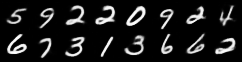

Result Image Saved!


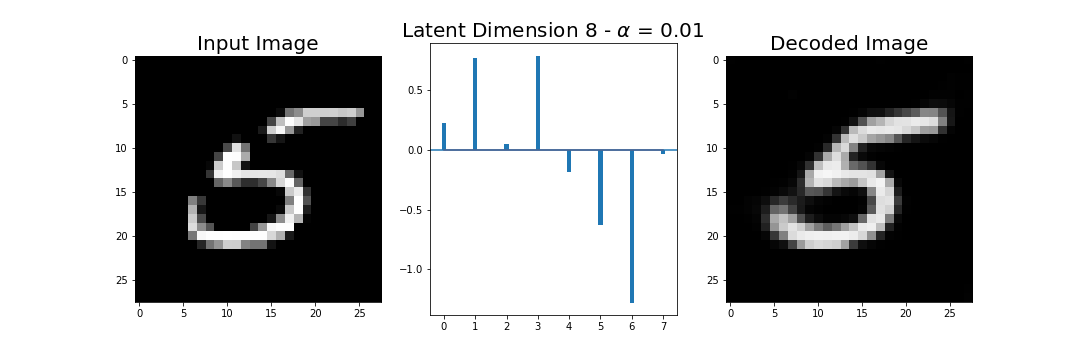

Spike and Slab Prior
Save image


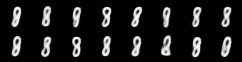

Gaussian Prior
Save image


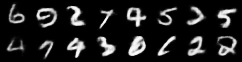

Iteration:  6
Loss 3720422.1580810547
Z sum:  tensor(202047.5938, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  7
Loss 3638366.223388672
Z sum:  tensor(214214.4062, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  8
Loss 3570064.791870117
Z sum:  tensor(224455.3750, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  9
Loss 3520160.2052001953
Z sum:  tensor(232497.4688, device='cuda:0', grad_fn=<SumBackward0>)
Iteration: 10
Loss: 3481098.0213623047
Z sum:  tensor(237920.1406, device='cuda:0')


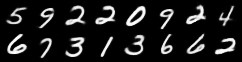

Result Image Saved!


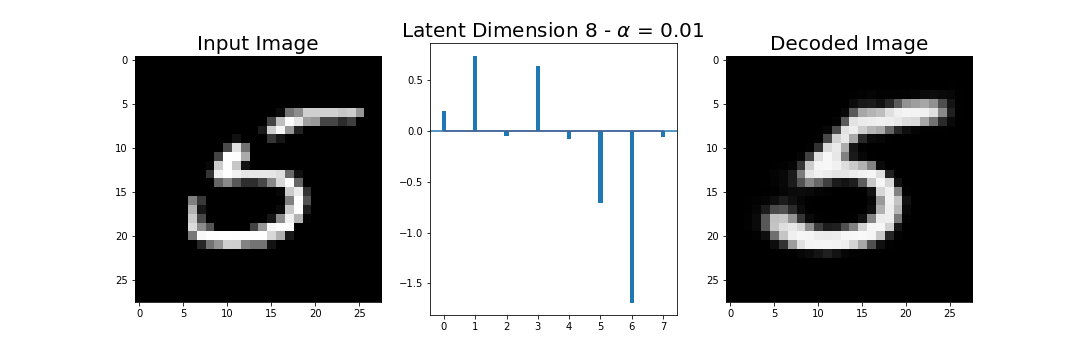

Spike and Slab Prior
Save image


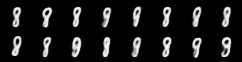

Gaussian Prior
Save image


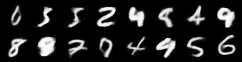

Iteration:  11
Loss 3429519.5361328125
Z sum:  tensor(249048.7500, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  12
Loss 3388616.938598633
Z sum:  tensor(256843.3594, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  13
Loss 3357285.155151367
Z sum:  tensor(264263.6875, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  14
Loss 3331558.8184814453
Z sum:  tensor(269238.9062, device='cuda:0', grad_fn=<SumBackward0>)
Iteration: 15
Loss: 3304367.108520508
Z sum:  tensor(276559.5938, device='cuda:0')


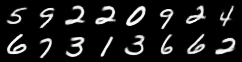

Result Image Saved!


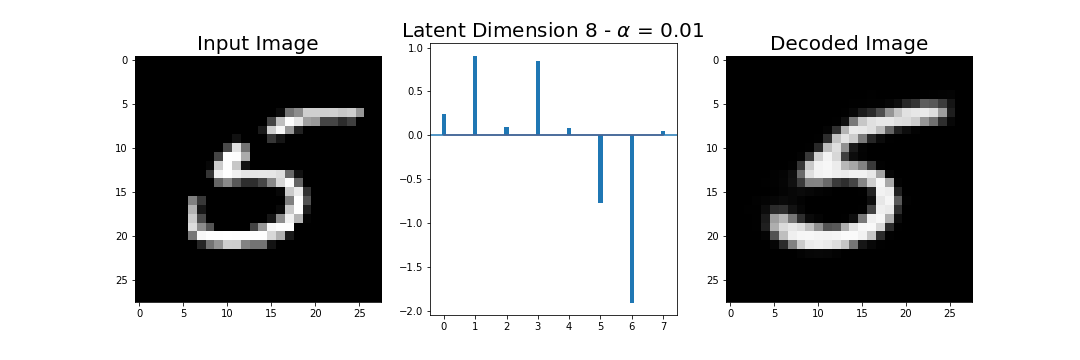

Spike and Slab Prior
Save image


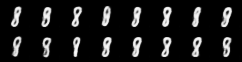

Gaussian Prior
Save image


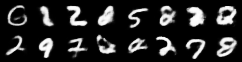

Iteration:  16
Loss 3280706.2189941406
Z sum:  tensor(280676.1875, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  17
Loss 3252945.6484375
Z sum:  tensor(287082.1875, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  18
Loss 3231126.1856689453
Z sum:  tensor(292239.9062, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  19
Loss 3219936.1208496094
Z sum:  tensor(295326.4375, device='cuda:0', grad_fn=<SumBackward0>)
Iteration: 20
Loss: 3201319.871948242
Z sum:  tensor(297264.5625, device='cuda:0')


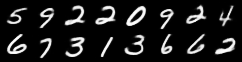

Result Image Saved!


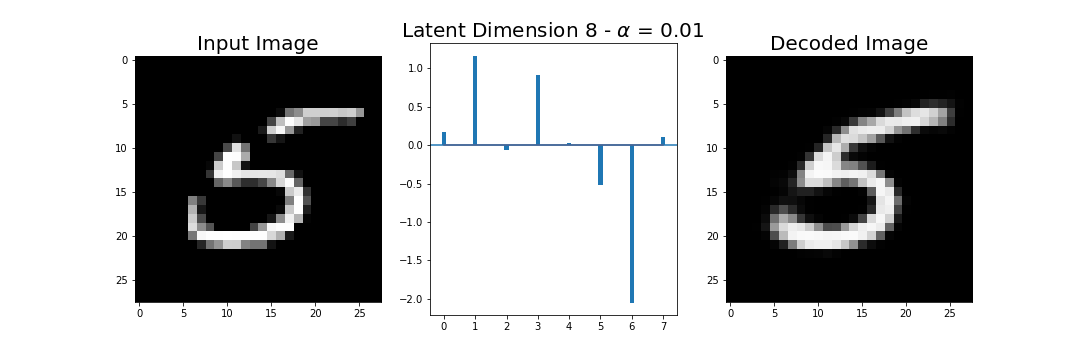

Spike and Slab Prior
Save image


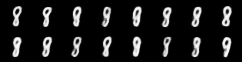

Gaussian Prior
Save image


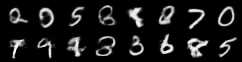

Iteration:  21
Loss 3187190.8159179688
Z sum:  tensor(298690.0625, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  22
Loss 3165125.5963134766
Z sum:  tensor(303581.3750, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  23
Loss 3147676.668334961
Z sum:  tensor(305263.7188, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  24
Loss 3148745.767944336
Z sum:  tensor(305381.1875, device='cuda:0', grad_fn=<SumBackward0>)
Iteration: 25
Loss: 3128498.660522461
Z sum:  tensor(309309., device='cuda:0')


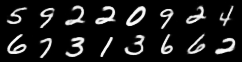

Result Image Saved!


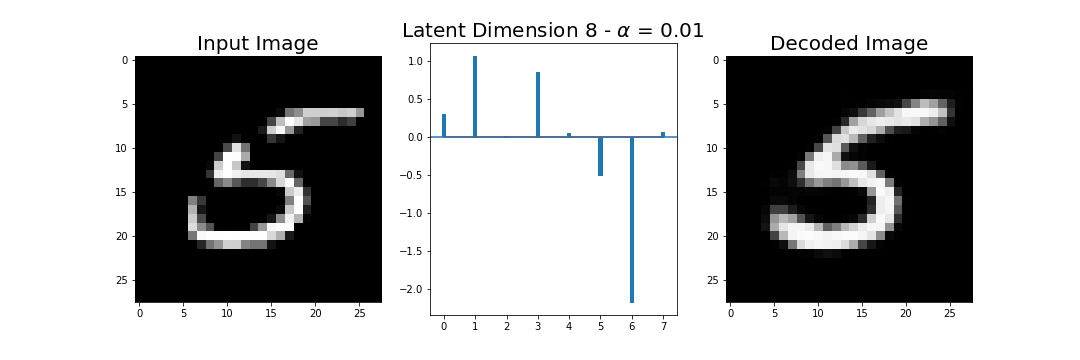

Spike and Slab Prior
Save image


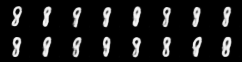

Gaussian Prior
Save image


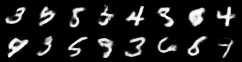

Iteration:  26
Loss 3107670.8404541016
Z sum:  tensor(312248.1250, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  27
Loss 3096868.8184814453
Z sum:  tensor(314170.0625, device='cuda:0', grad_fn=<SumBackward0>)
Iteration:  28
Loss 3078521.756713867
Z sum:  tensor(317141.6250, device='cuda:0', grad_fn=<SumBackward0>)
Iteration: 29
Loss: 3072611.6291503906
Z sum:  tensor(317780.1875, device='cuda:0')


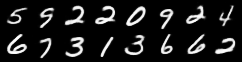

Result Image Saved!


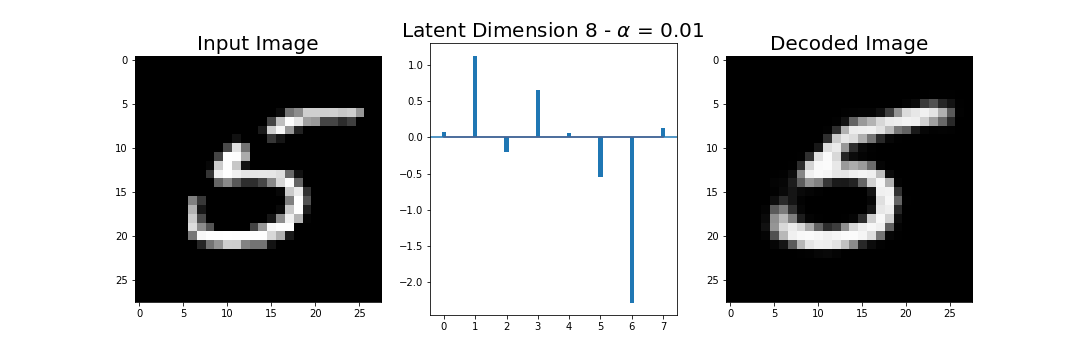

Spike and Slab Prior
Save image


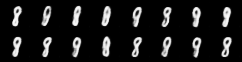

Gaussian Prior
Save image


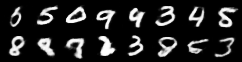

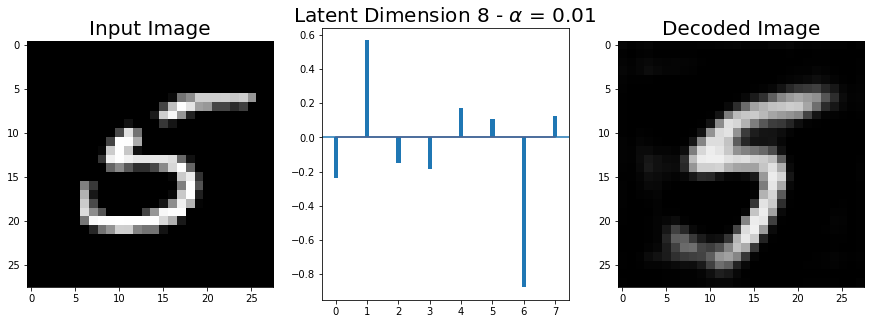

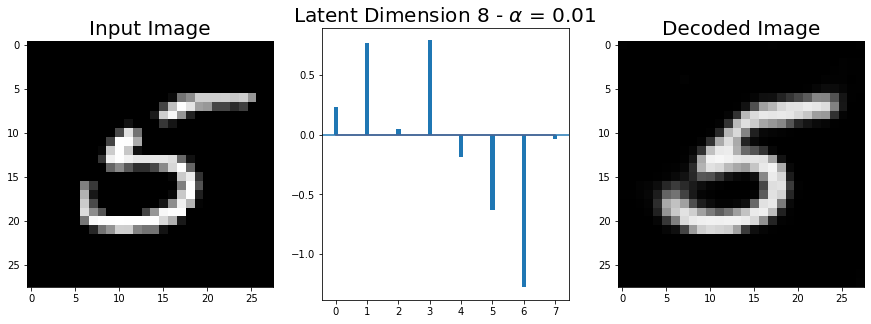

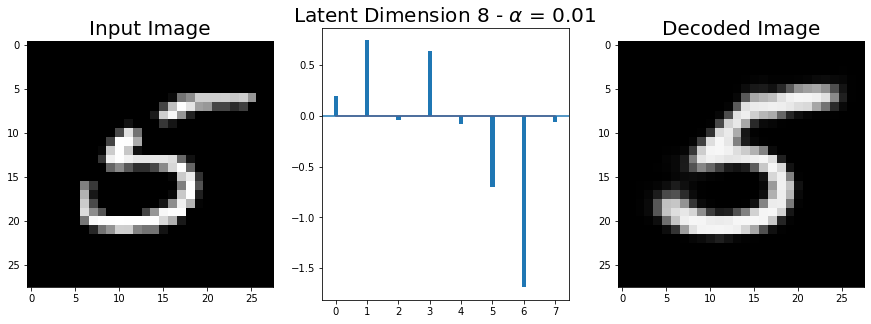

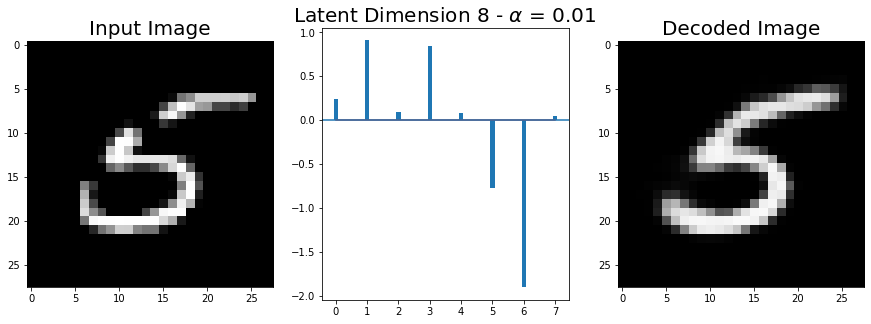

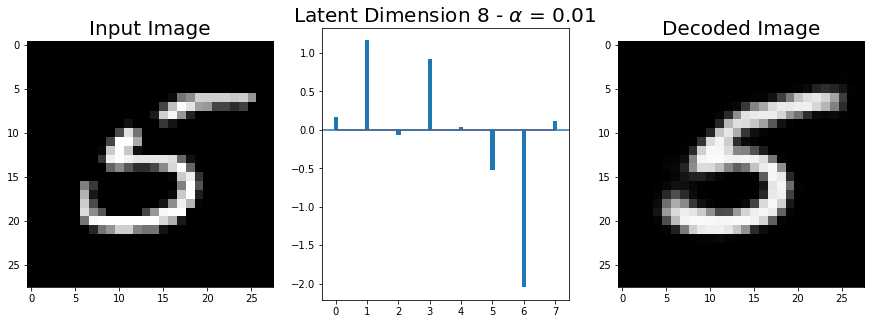

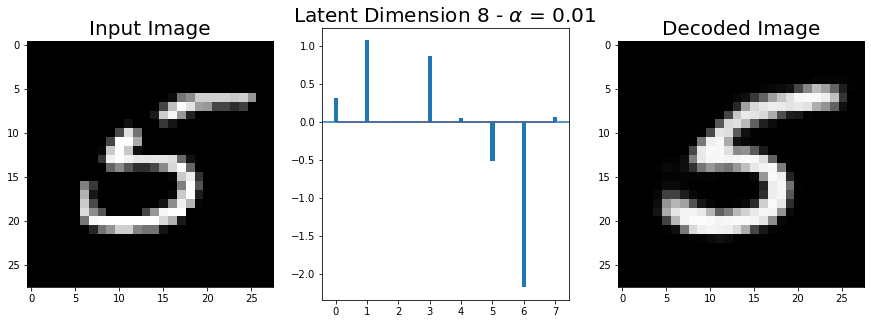

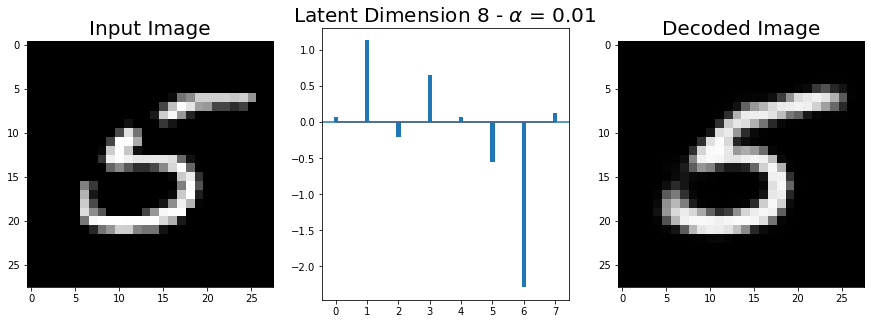

In [27]:
# Alternating back propagation
stop = 0
for epochs in range(epo):
    #print("Epochs: ", epochs)
    if stop == 1:
      break
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader): # Get mini batch of images and corresponding latent variable
        #print("Batch_idx: ", batch_idx)
        if stop == 1:
          break
        data = data.cuda()
        z_batch = z[batch_size * batch_idx:batch_size * batch_idx + data.shape[0]].detach().requires_grad_()

      ### Inferential, do multiple langevin sampling, update latent variable Z 
        for j in range(l_step):
            if stop == 1:
              break     
            #print('L_step:', j)

            if z_batch.grad is not None:
              z_batch.grad.zero_()

            for a in g.parameters():
              if (a != a).any():
                print("GGGGG")
                print("Model: ", a)
                stop = 1
                break  

            if stop == 1:
              break

            pred = g(z_batch) # Get generated result

            loss = loss_function(data, pred, sigma, s1, s2, alpha, z_batch) # Calculate Loss
            loss.backward() # Back propagation

            u = torch.FloatTensor(z_batch.shape[0], z_batch.shape[1]).normal_(0, 1).cuda() # Sample gaussian noise and to GOU

            if (z_batch.grad != z_batch.grad).any():
              print("Z_BATCH")
              print(z_batch.grad)
              print("Z_batch:", z_batch)
              stop = 1
              break

            #print("Update Z")
            if (der_z(z_batch, s1, s2, alpha) != der_z(z_batch, s1, s2, alpha)).any():
              print("Z_GRAD")
              stop = 1
              break

            z_batch = z_batch - (lang_sigma ** 2) / 2 * (z_batch.grad - der_z(z_batch, s1, s2, alpha)) # Gradient descent for latent variable Z
            z_batch = z_batch + lang_sigma * u
            #print(z_batch)

            z_batch = z_batch.detach().requires_grad_() # Free latent variable from computational graph, to make it leaf node
            #print(z_batch)

            #print("Z sum langevin: ", torch.pow(z_batch, 2).sum())
            if (z_batch != z_batch).any():
              print("ZZZZ")
              stop = 1
              break
        z[batch_size * batch_idx:batch_size * batch_idx + data.shape[0]] = z_batch # Store latent variable 
        #print("Z sum batch: ", torch.pow(z, 2).sum())
    
        ### Learning, Update model parameter
        opt_g.zero_grad() # Clear gradient information
        pred = g(z_batch) # Get generated result
        loss = loss_function(data, pred, sigma, s1, s2, alpha, z_batch) # Calculate Loss
        loss.backward() # Back propagation
        #torch.nn.utils.clip_grad_norm_(g.parameters(), 1) # Clip gradient to avoid gradient exploding
        #print("Update G")
        opt_g.step() # Gradient descent
        total_loss = total_loss + loss.item() # Sum loss

    # For every 5 epchs, draw random samples and plot generated image
    if epochs % 5 == 0 or epochs == epo - 1:
        with torch.no_grad(): # Print Iteration number, loss and sum of squared latent variables
            print("Iteration:", epochs)
            print("Loss:", total_loss)
            print("Z sum: ", torch.pow(z, 2).sum())
            result = g(z_batch[0:16]) # Showing only 16 original samples
            #result = (g(z_batch[0:8]) + 1) / 2
            # Plot Reconstructed Image
            save_image(result.view(16, channel_im, dim_im, dim_im), './rec_' + '.png')
            im = Image.open("rec_.png") # Save Image and Plot
            display(im) 
            #print("Z: ", z) 
            plot_latent(data[0:1], z_batch[0:1])
            im = Image.open('sc_result.png')
            display(im)
            # Generate 32 random samples
            print("Spike and Slab Prior")
            test_z = alpha * torch.FloatTensor(16, dim_z).normal_(0, s1) + (1 - alpha) * torch.FloatTensor(16, dim_z).normal_(0, s2)
            #zero_z(test_z)
            test_z = test_z.cuda()
            result = g(test_z)
            # result = (g(test_z) + 1) / 2
            print("Save image")
            save_image(result.view(result.shape[0], channel_im, dim_im, dim_im), './gen_' + '.png')
            im = Image.open("gen_.png") # Save Image and Plot
            display(im)

            print("Gaussian Prior")
            test_z = torch.FloatTensor(16, dim_z).normal_(0, s1)# + (1 - alpha) * torch.FloatTensor(32, dim_z).normal_(0, s2)
            #zero_z(test_z)
            test_z = test_z.cuda()
            result = g(test_z)
            # result = (g(test_z) + 1) / 2
            print("Save image")
            save_image(result.view(result.shape[0], channel_im, dim_im, dim_im), './gen_' + '.png')
            im = Image.open("gen_.png") # Save Image and Plot
            display(im)
            
    else:   # Print Iteration number, loss and sum of squared latent variables if epochs is not divisible by 10      
        print("Iteration: ", epochs)
        print("Loss", total_loss)
        print("Z sum: ", torch.pow(z, 2).sum())


    torch.save(g.state_dict(), 'paused_model.pt')

In [0]:
torch.save(g.state_dict(), 'model_8_0.001_0.05_n0.3_30_good.pt')

In [0]:
# Load Model
g = generator()
state_dict = torch.load("model_8_0.001_0.05_n0.3_30_good.pt")
g.load_state_dict(state_dict)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
g.to(device=device)

In [0]:
def plot_z(z):
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

  ax0.bar(np.arange(z.shape[1]), height=z.cpu().detach().numpy()[0], width=1/7, align='center')
  ax0.stem(np.arange(z.shape[1]), z.cpu().detach().numpy()[0], markerfmt=' ', use_line_collection=True)
#  ax1.scatter(np.arange(z.shape[1]), z.cpu().detach().numpy()[0], color='blue')
  ax0.axhline(y=0)
  ax0.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % (z.shape[1], alpha), fontsize=20)
    
  img = g(z)
  img = torchvision.utils.make_grid(img.view(1,channel_im,dim_im,dim_im)).cpu().detach().numpy()
  ax1.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
  ax1.set_title('Decoded Image', fontsize=20)
  plt.subplots_adjust(hspace=0.5)
  plt.savefig('sc_result.png')

In [0]:
test_z = alpha * torch.FloatTensor(64, dim_z).normal_(0, s1).cuda() #+ (1 - alpha) * torch.FloatTensor(64, dim_z).normal_(0, s2)
#zero_z(test_z)

In [0]:
plot_z(test_z[3:4])

In [0]:
save_image(g((z_batch[0]/5).view(1, 100)).view(1, 1, 28, 28), 'test1.png')

In [0]:
# Plot Original Image
save_image(data.view(data.shape[0], channel_im  , dim_im, dim_im), './ori_' + '.png')

In [0]:
# Plot Reconstructed Image
save_image(result.view(result.shape[0], channel_im, dim_im, dim_im), './rec_' + '.png')

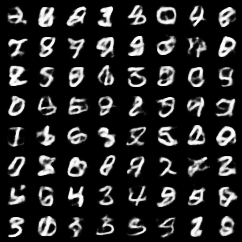

In [23]:
# Guassian Prior
test_z = torch.FloatTensor(64, dim_z).normal_(0, 1) 
test_z = test_z.cuda()
result = g(test_z)
save_image(result.view(result.shape[0], channel_im, dim_im, dim_im), './gen_' + '.png')
im = Image.open("gen_.png") 
display(im)

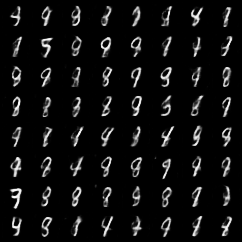

In [15]:
# Plot Generated Image  
test_z = alpha * torch.FloatTensor(64, dim_z).normal_(0, s1) + (1 - alpha) * torch.FloatTensor(64, dim_z).normal_(0, s2)
test_z = test_z.cuda()
result = g(test_z)
save_image(result.view(result.shape[0], channel_im, dim_im, dim_im), './gen_' + '.png')
im = Image.open("gen_.png") 
display(im)

Result Image Saved!


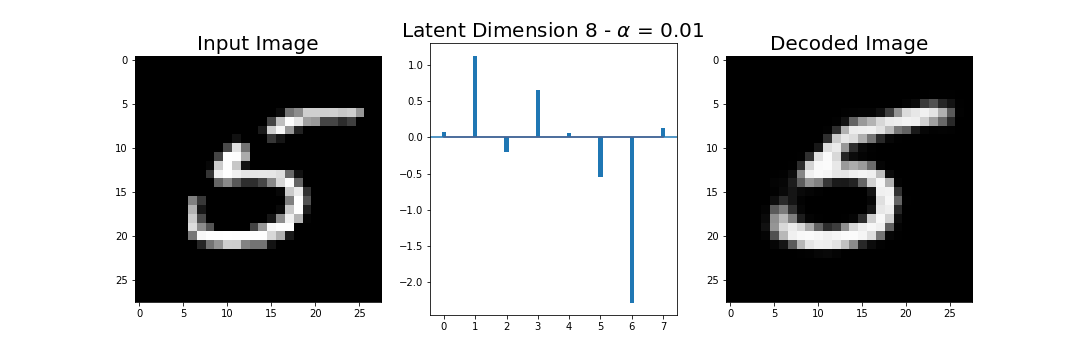

Result Image Saved!


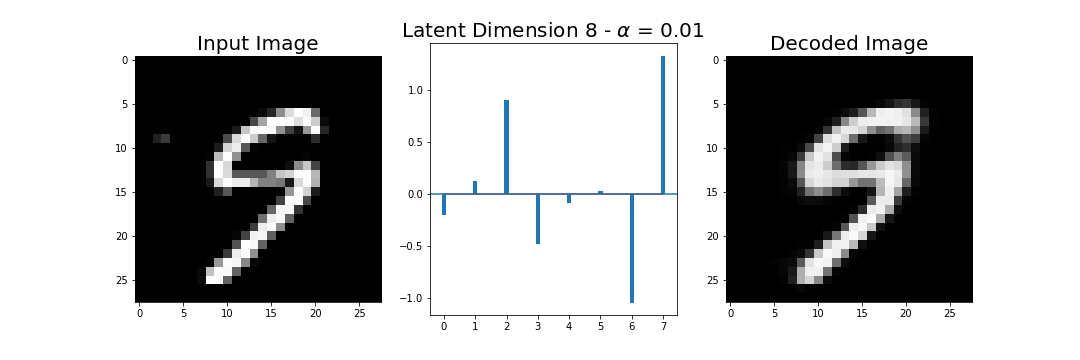

Result Image Saved!


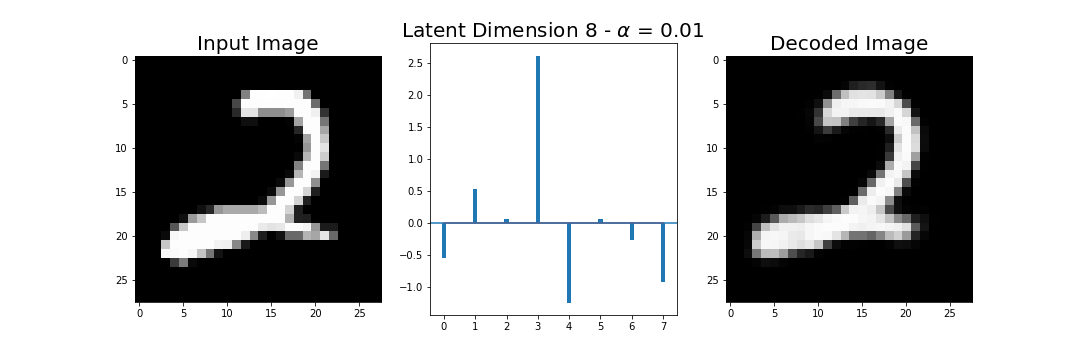

Result Image Saved!


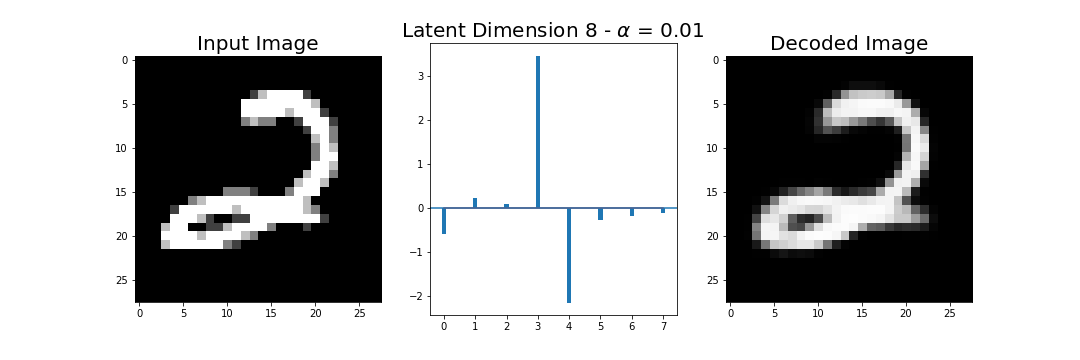

Result Image Saved!


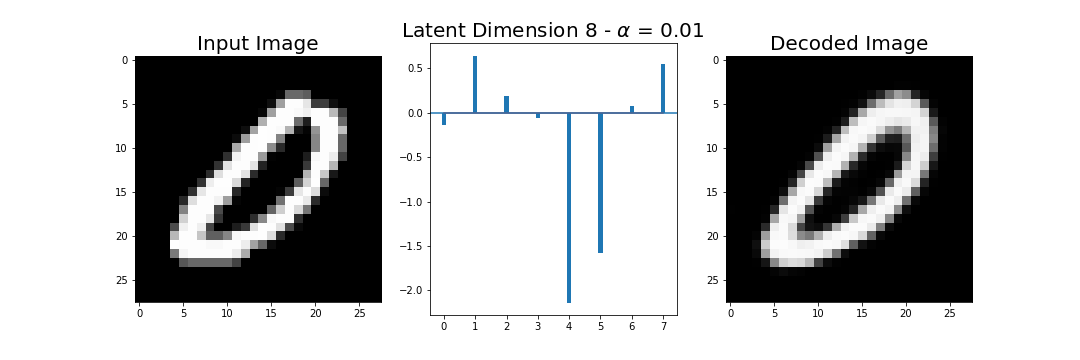

Result Image Saved!


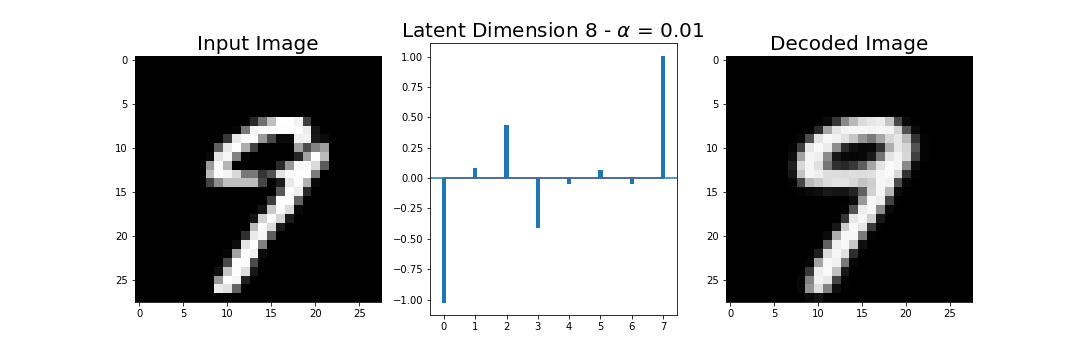

Result Image Saved!


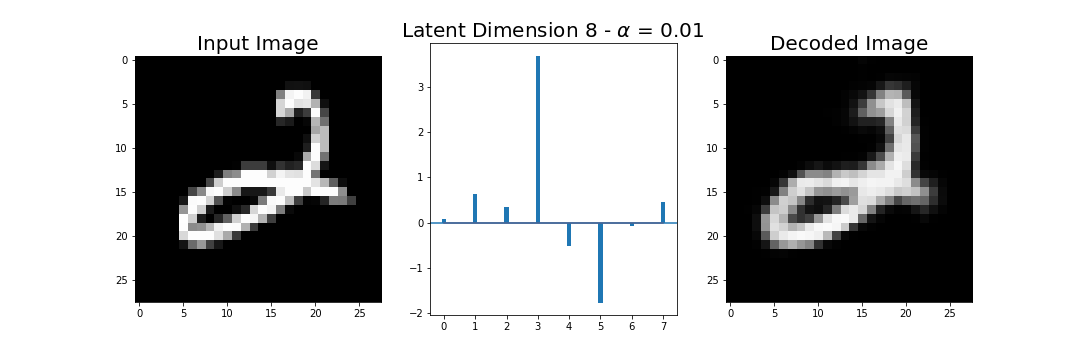

Result Image Saved!


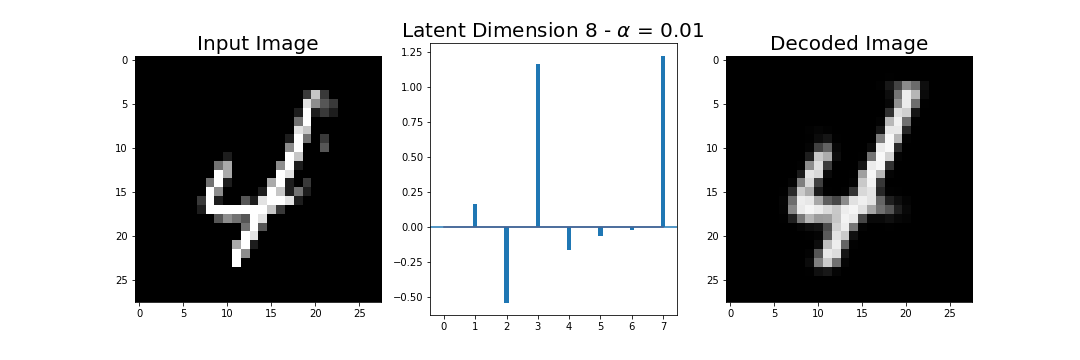

Result Image Saved!


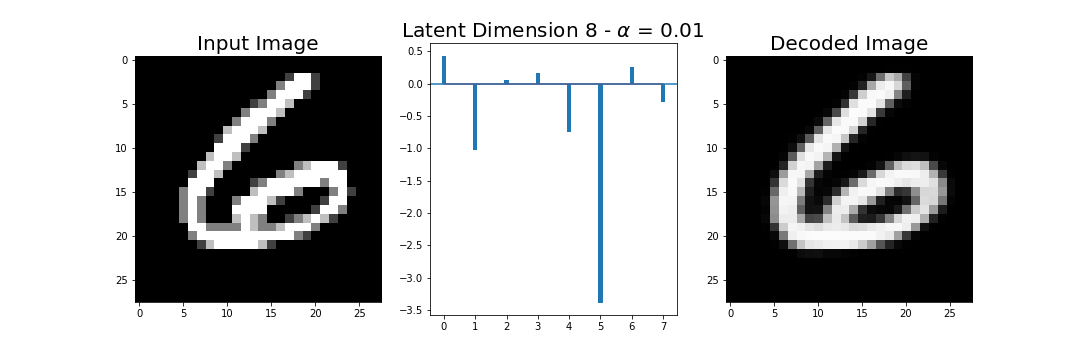

Result Image Saved!


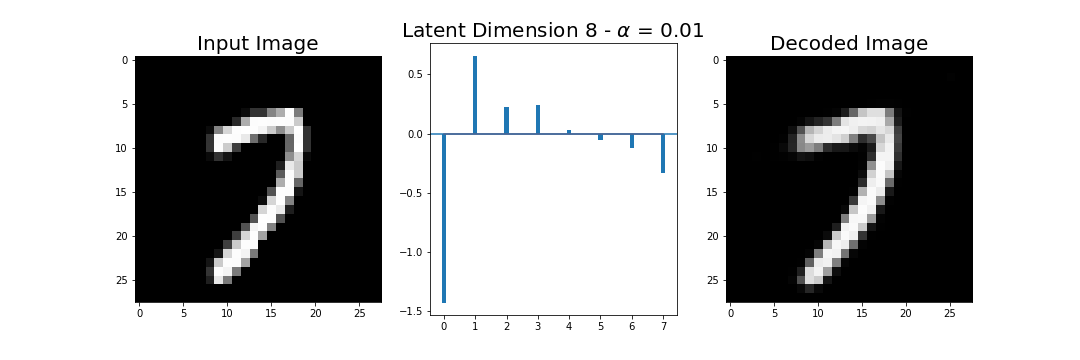

Result Image Saved!


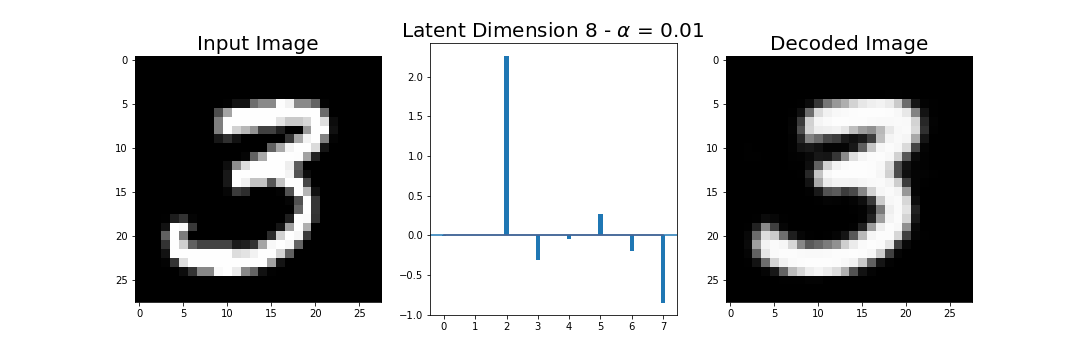

Result Image Saved!


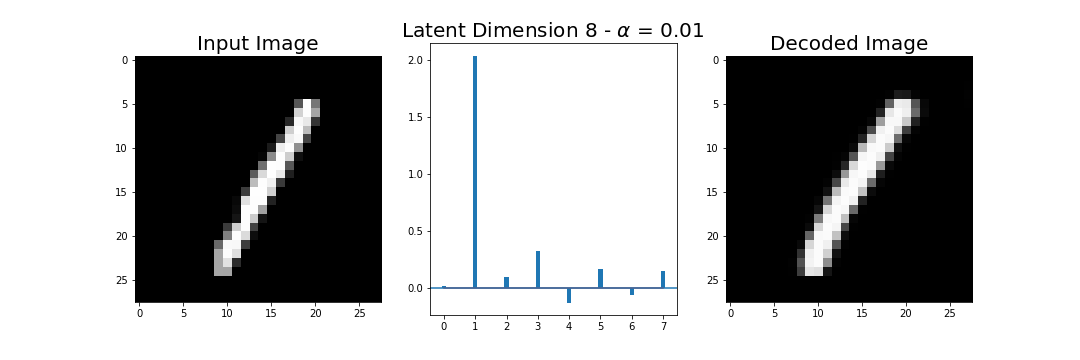

Result Image Saved!


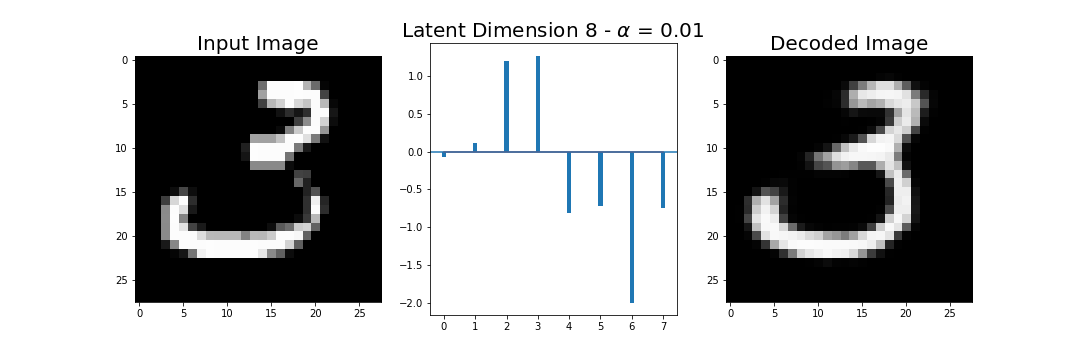

Result Image Saved!


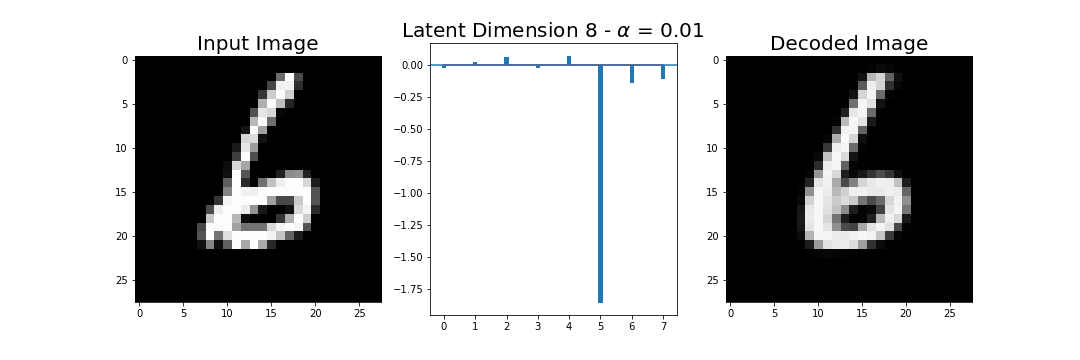

Result Image Saved!


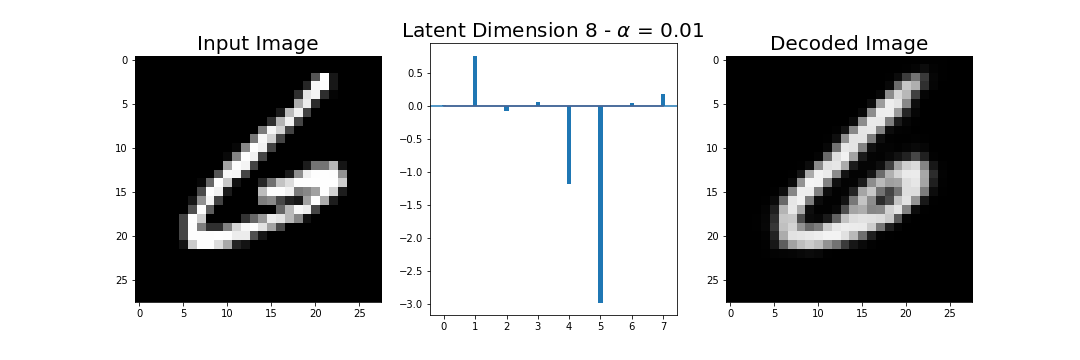

Result Image Saved!


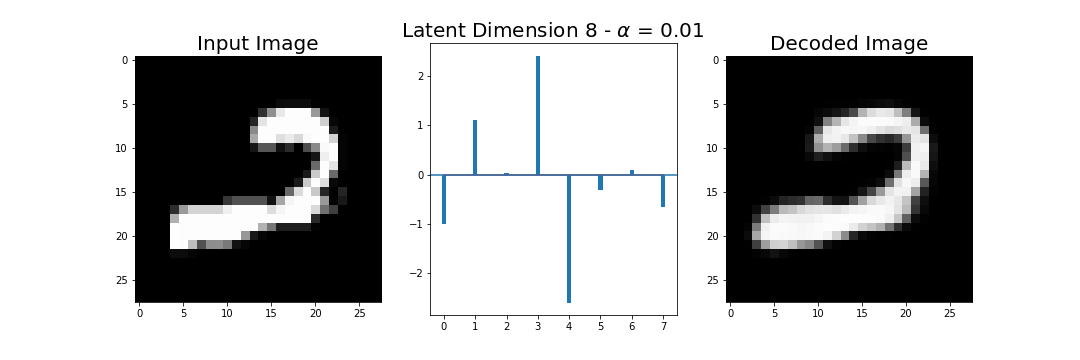

Result Image Saved!


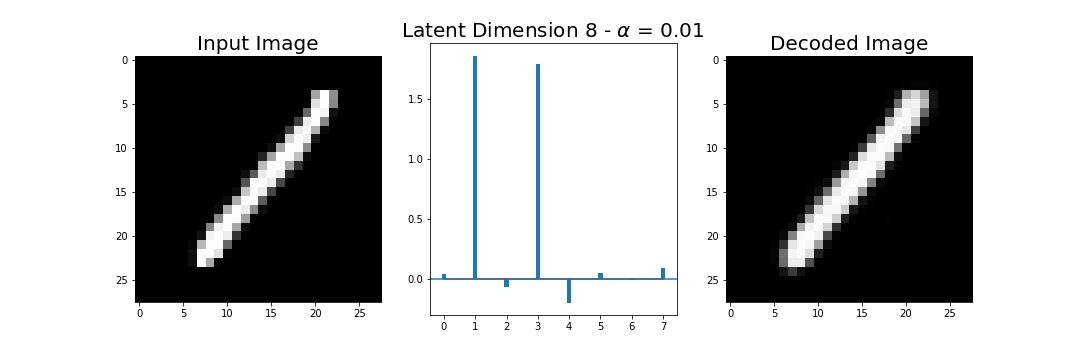

Result Image Saved!


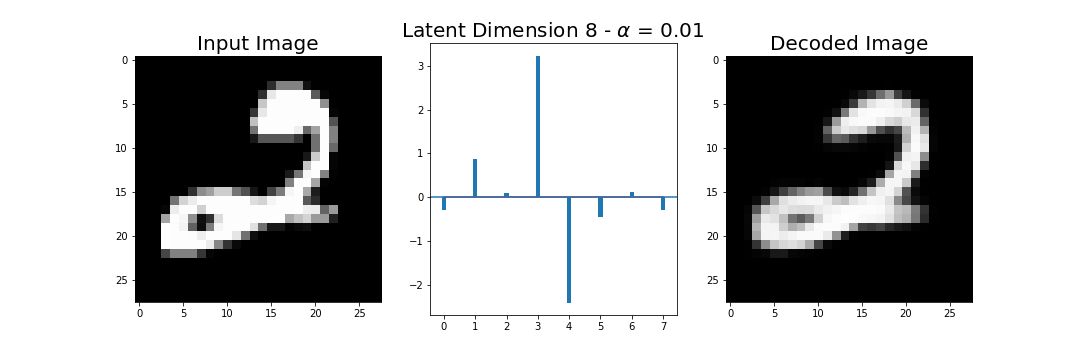

Result Image Saved!


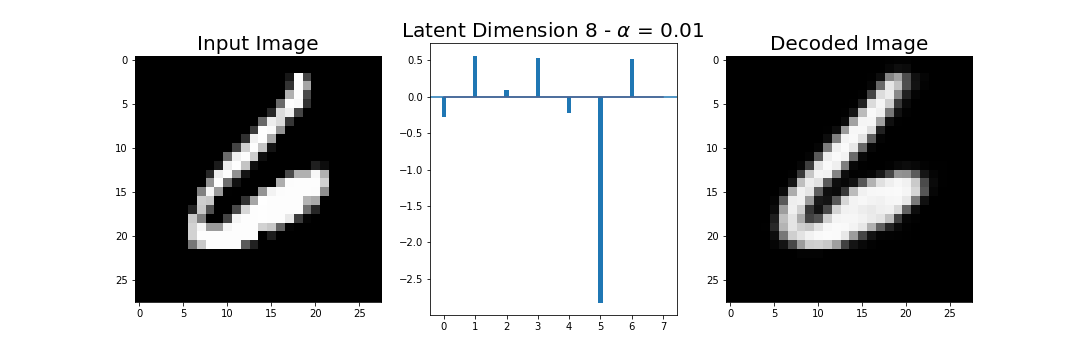

Result Image Saved!


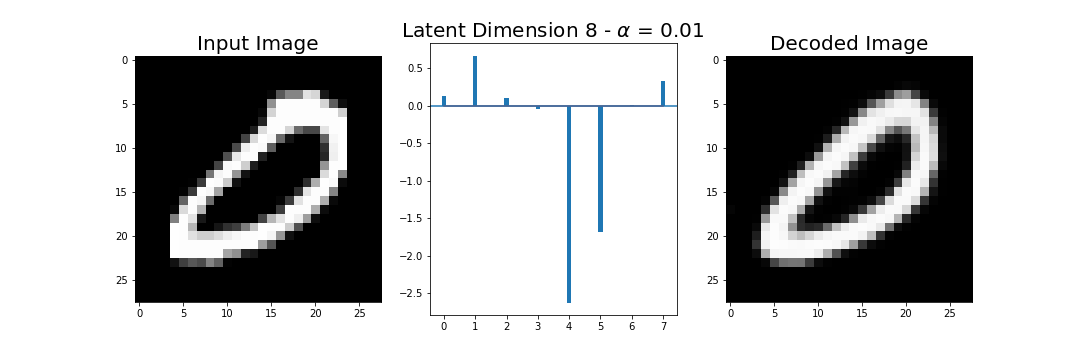

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


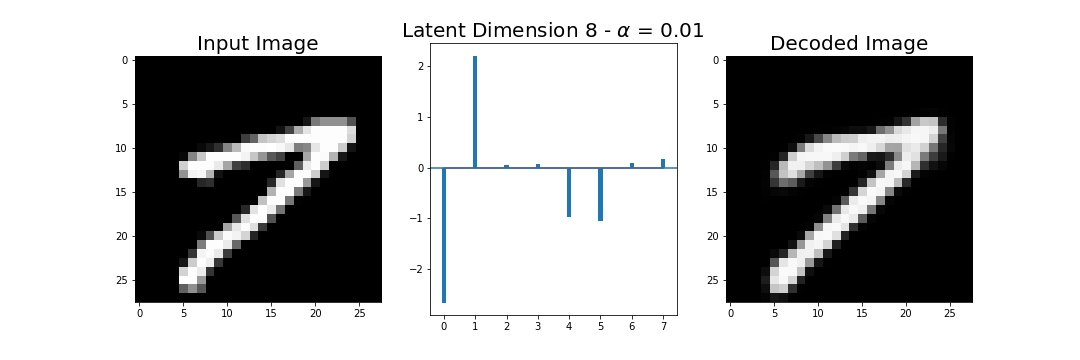

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


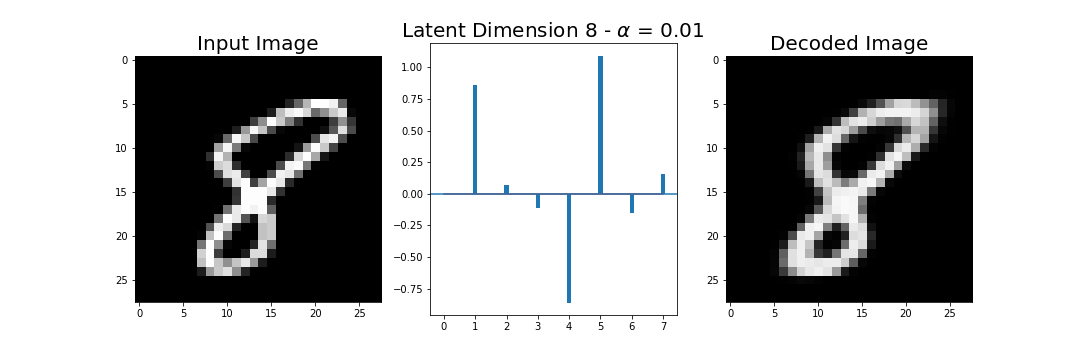

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


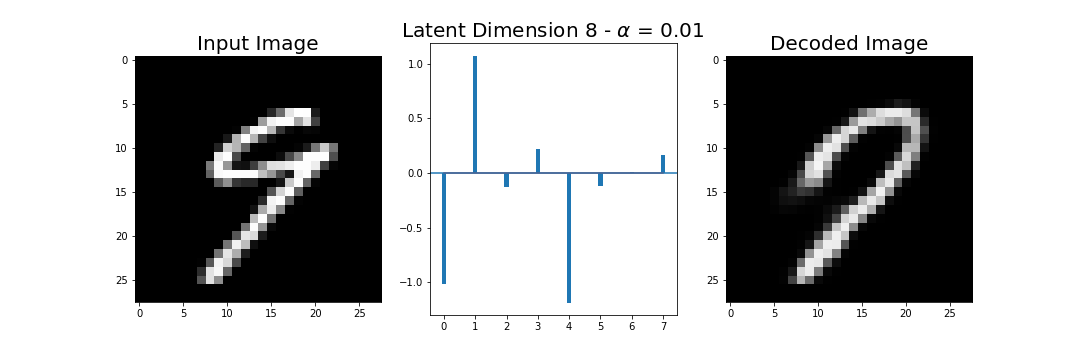

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


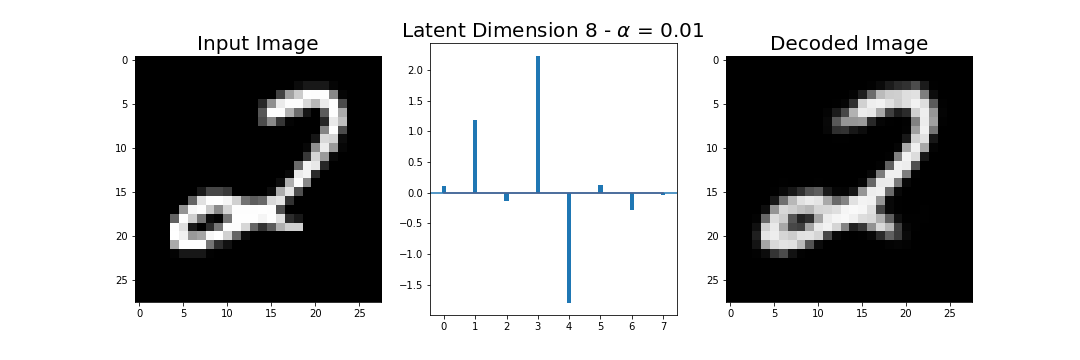

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


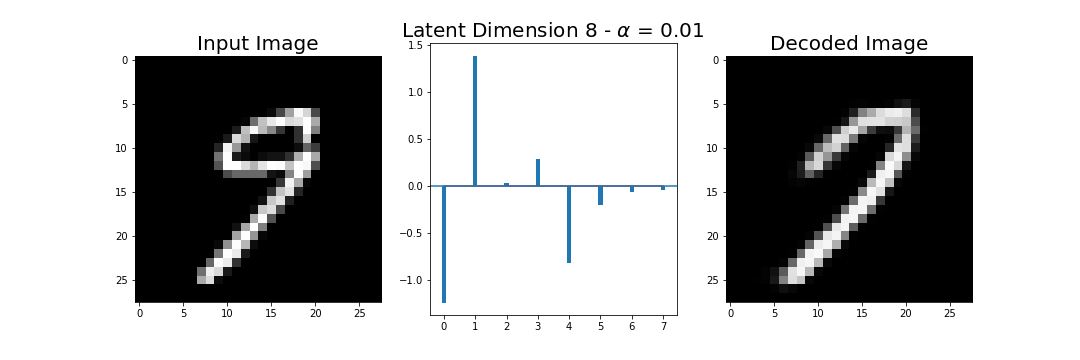

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


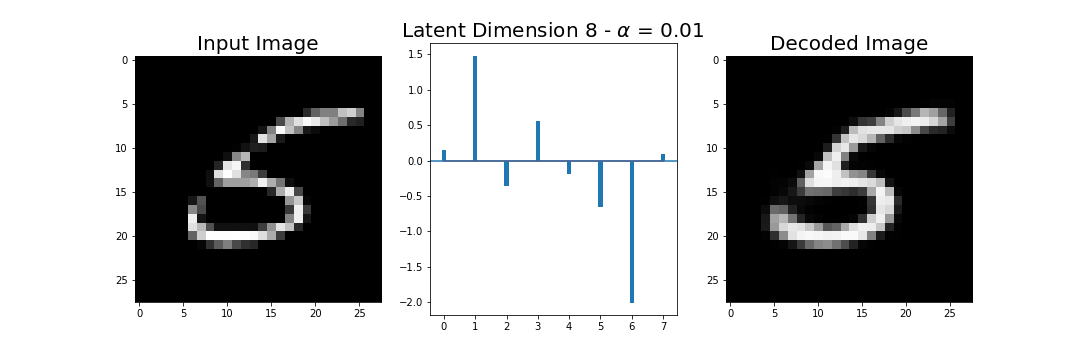

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


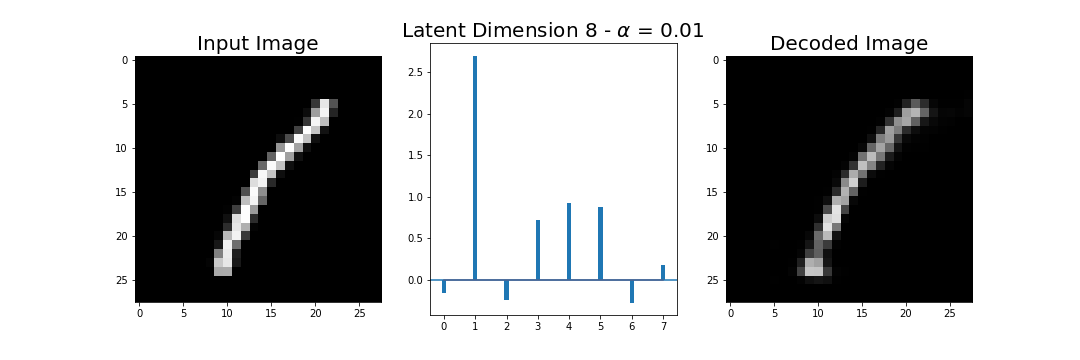

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


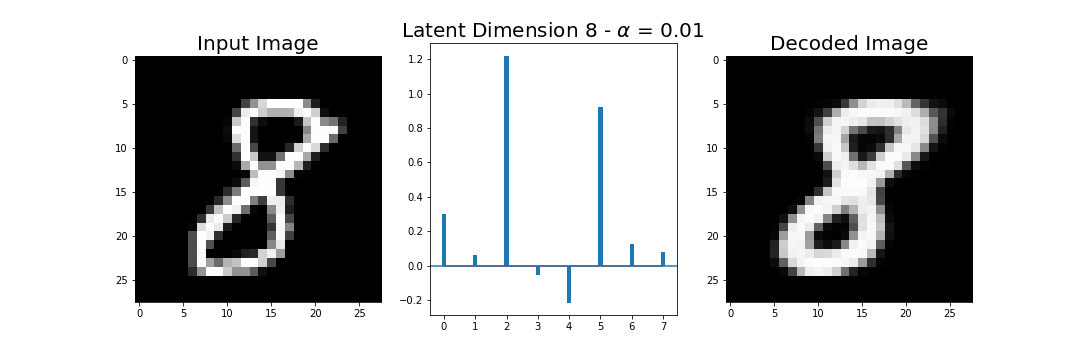

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


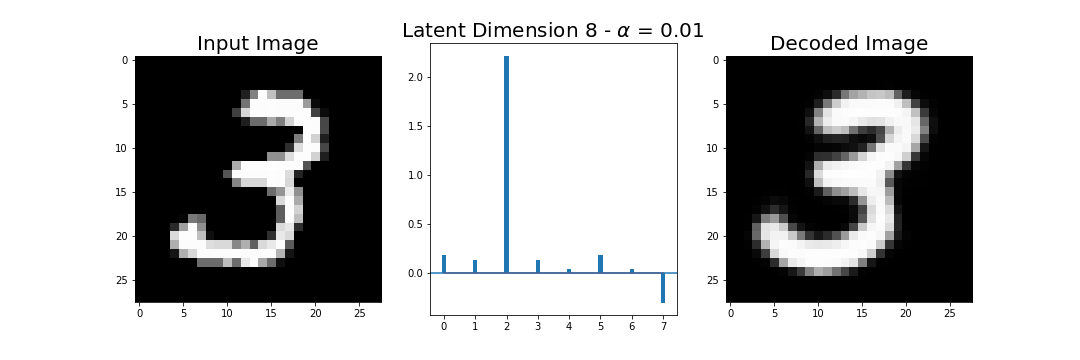

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


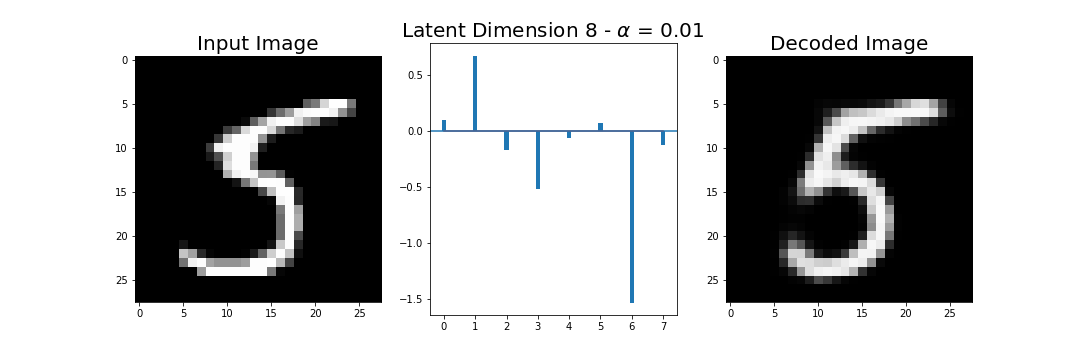

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


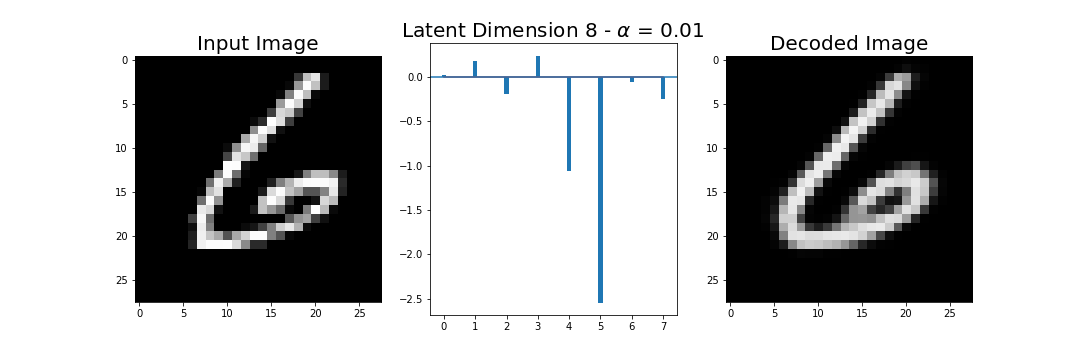

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Result Image Saved!


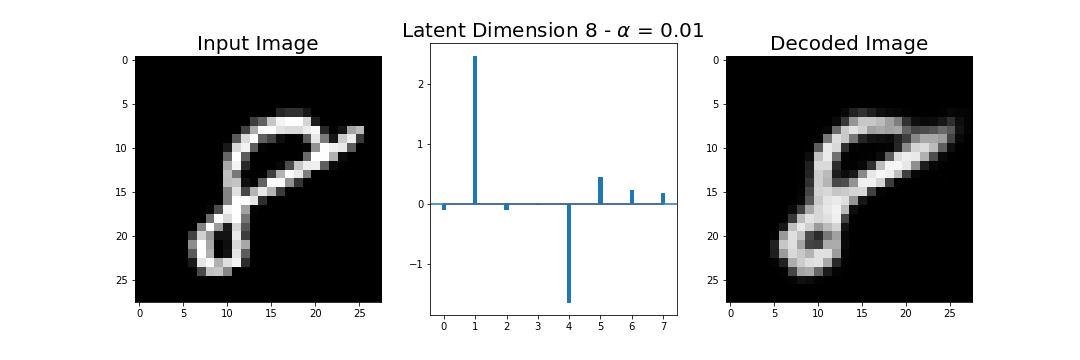

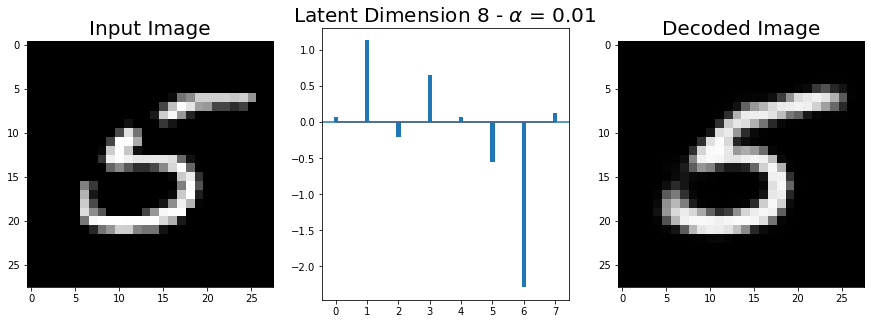

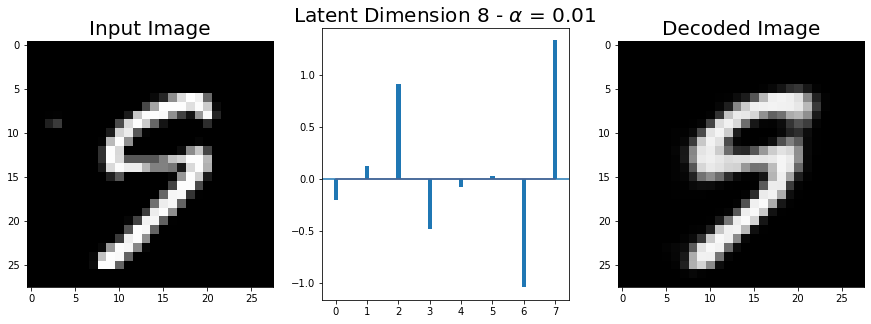

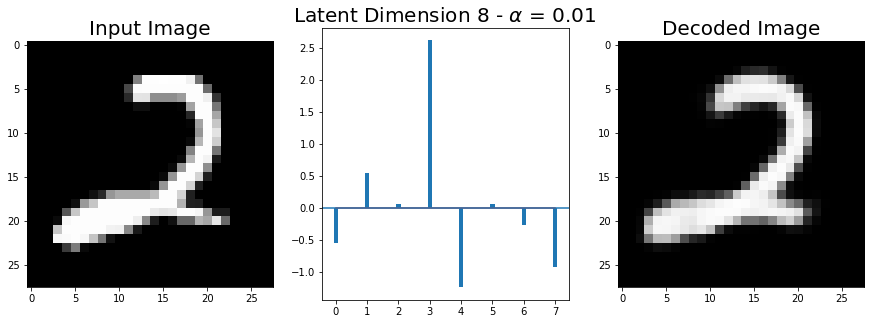

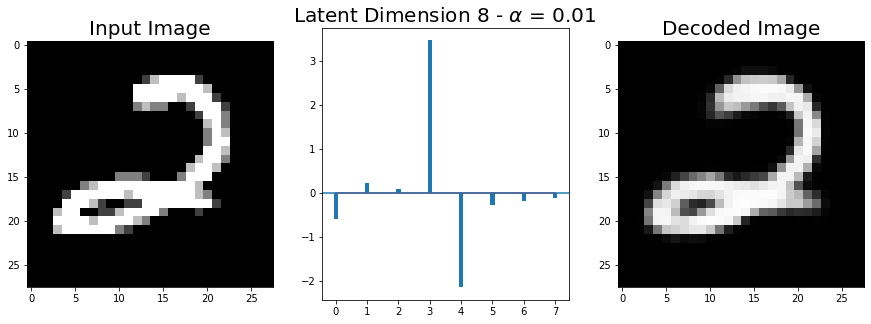

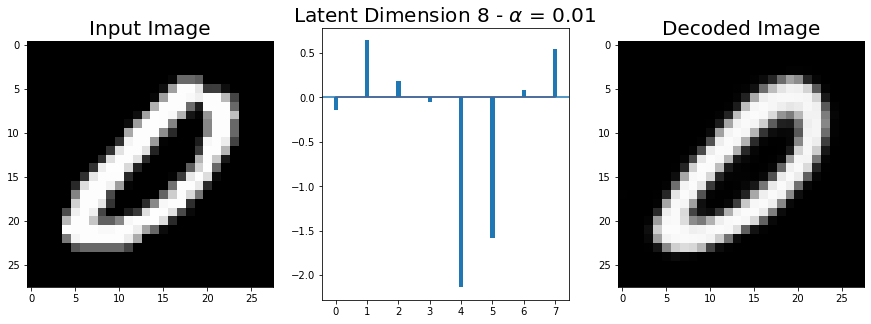

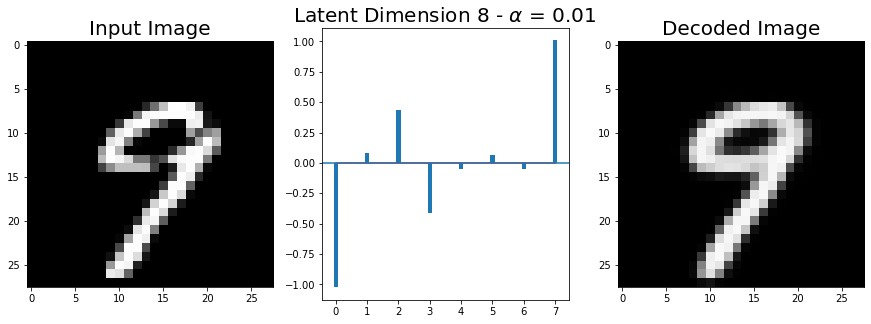

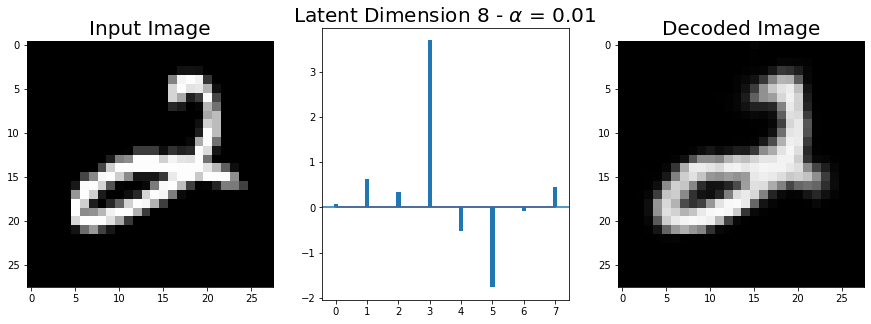

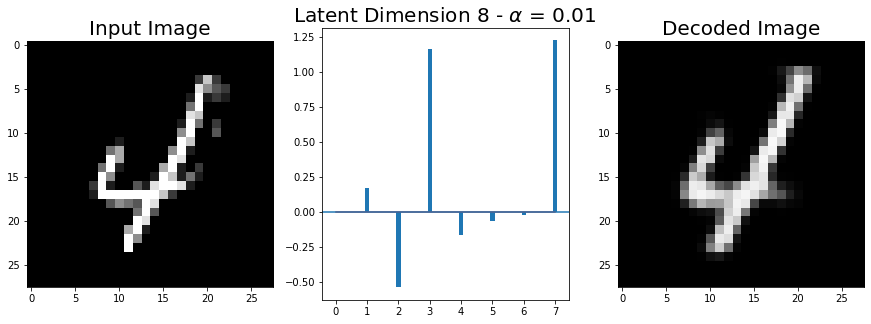

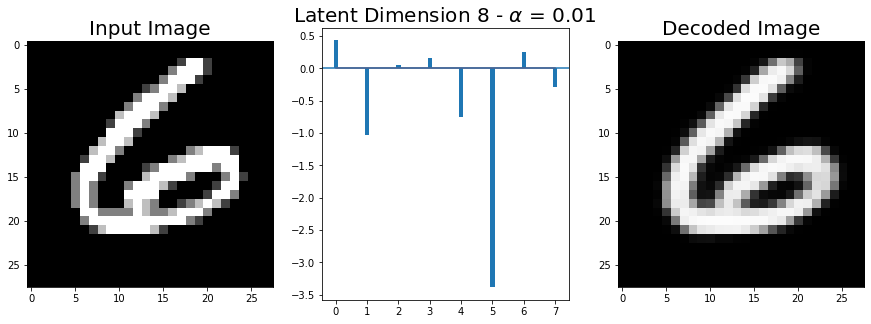

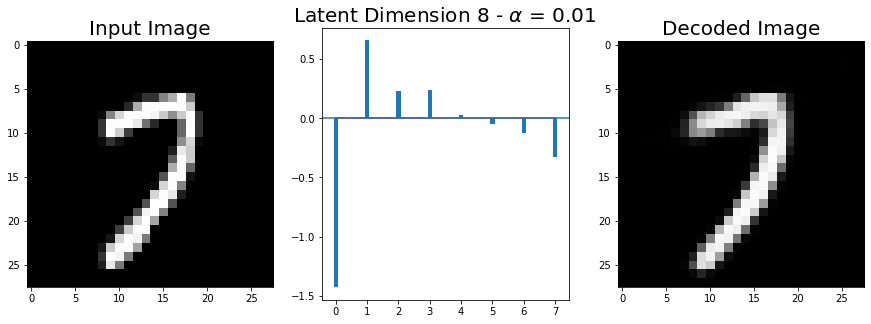

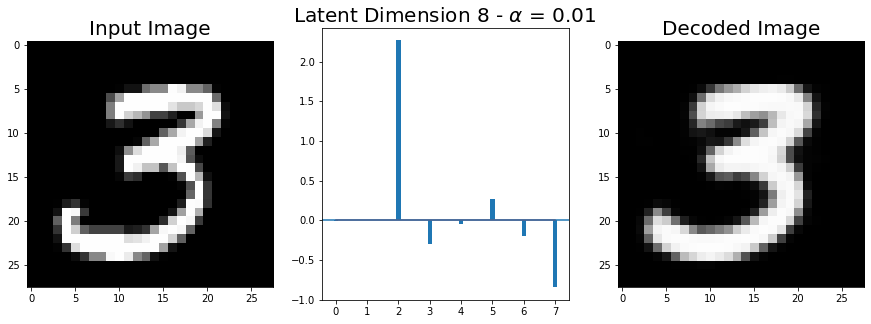

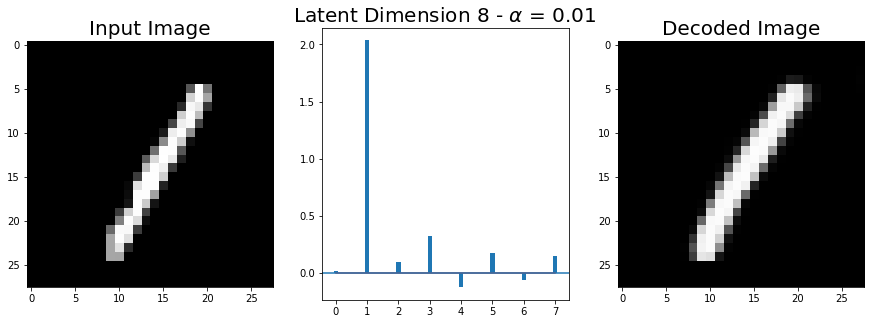

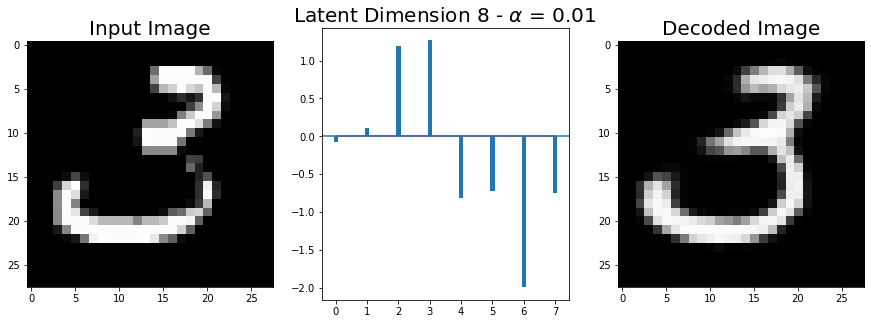

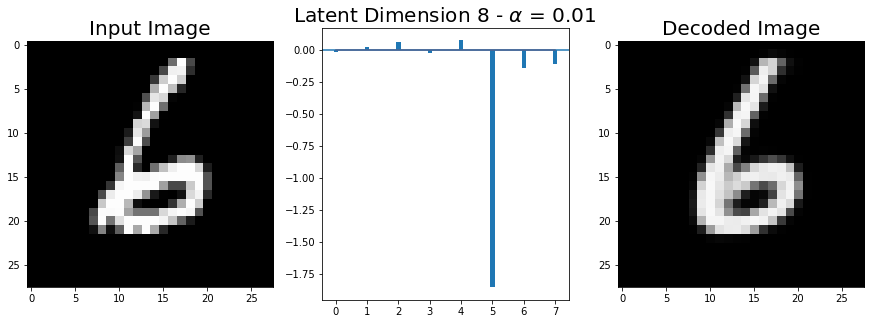

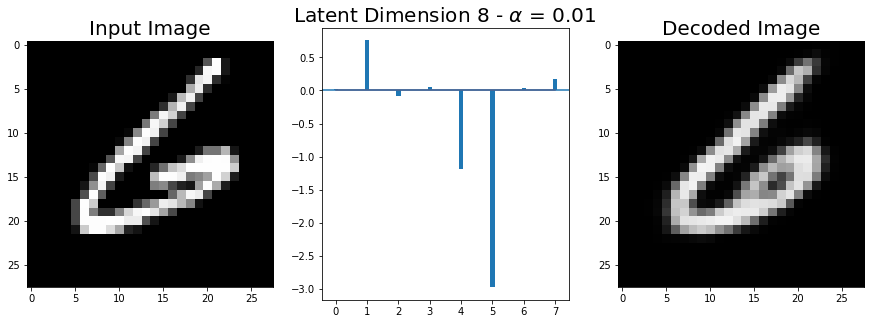

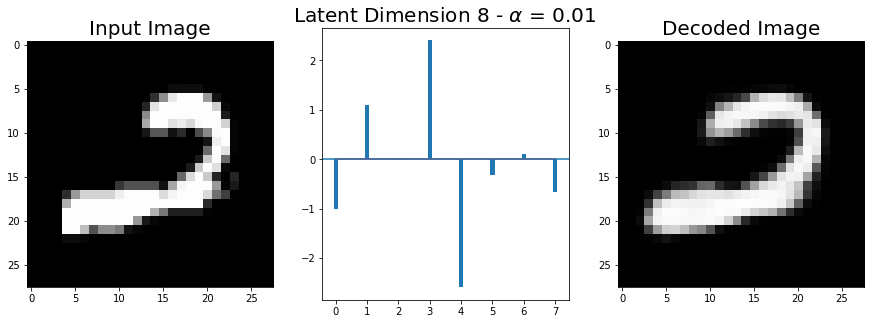

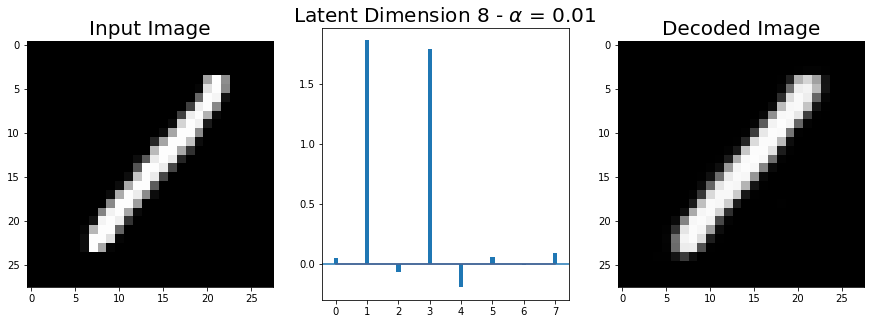

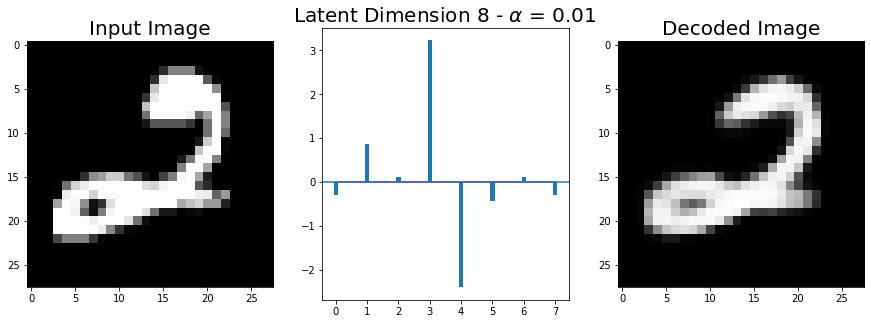

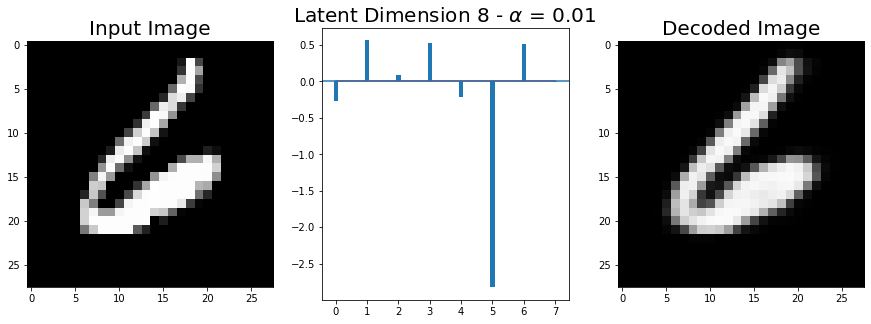

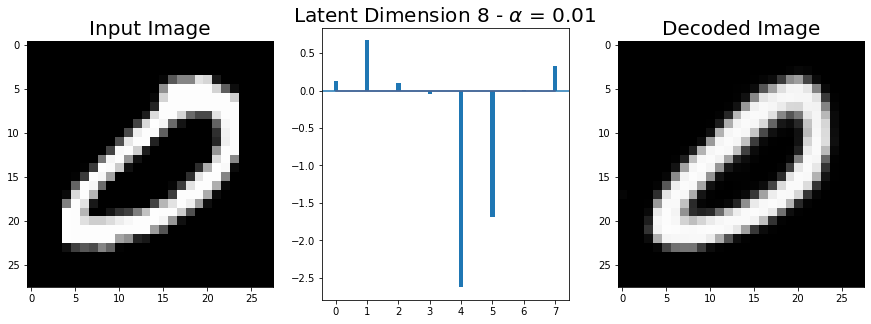

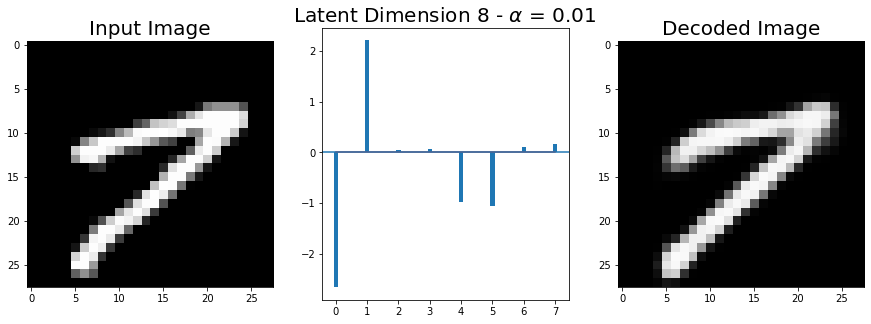

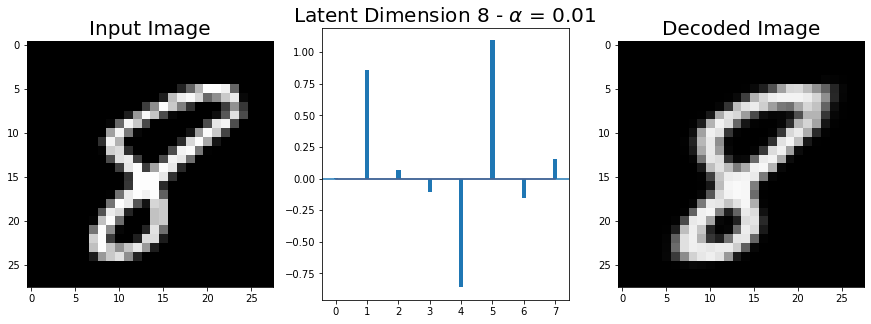

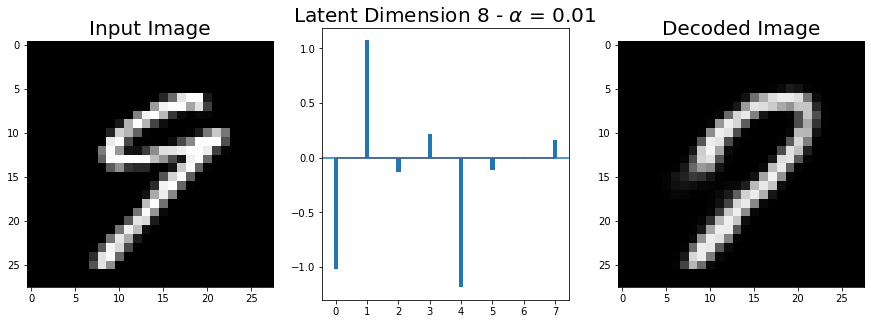

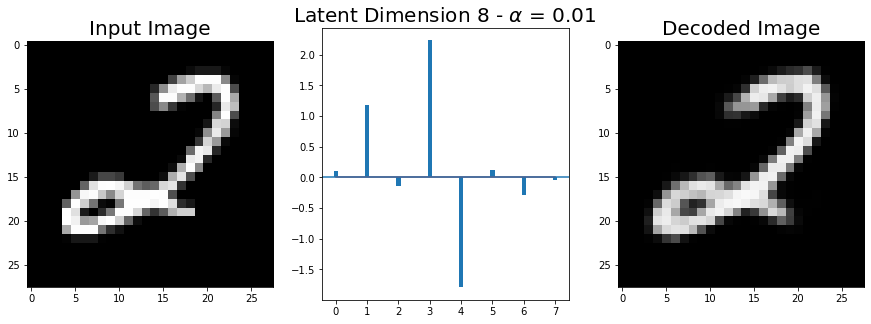

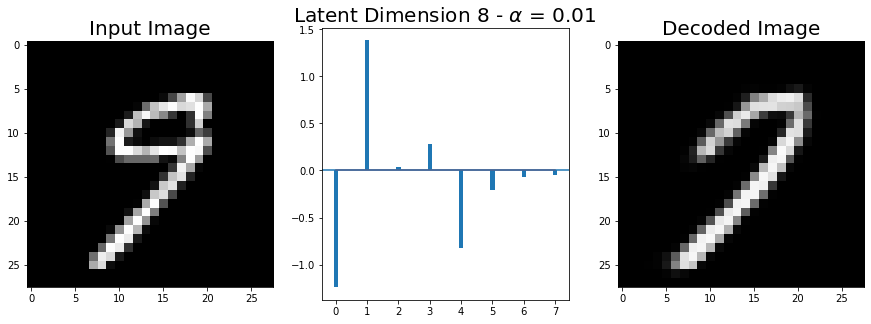

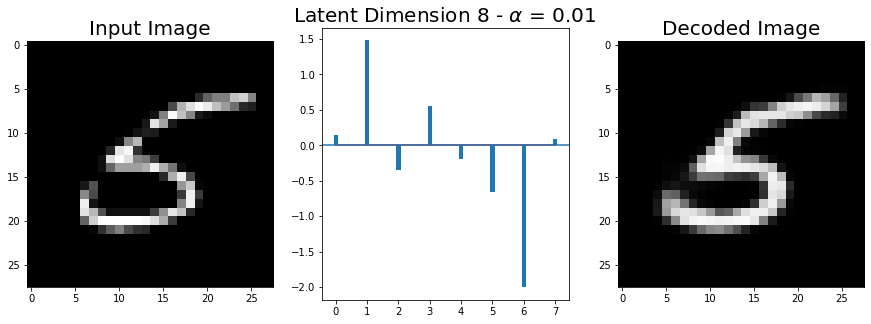

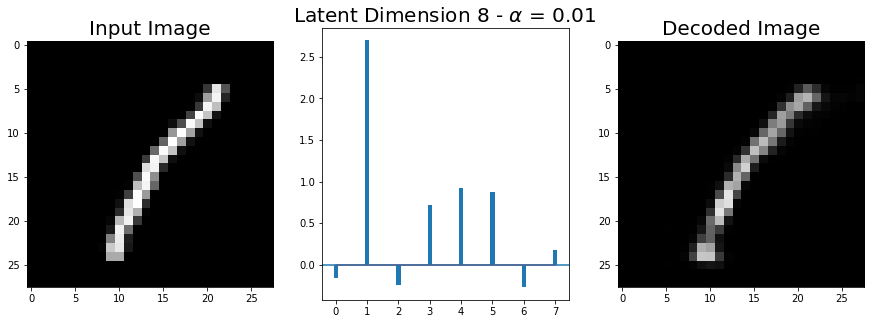

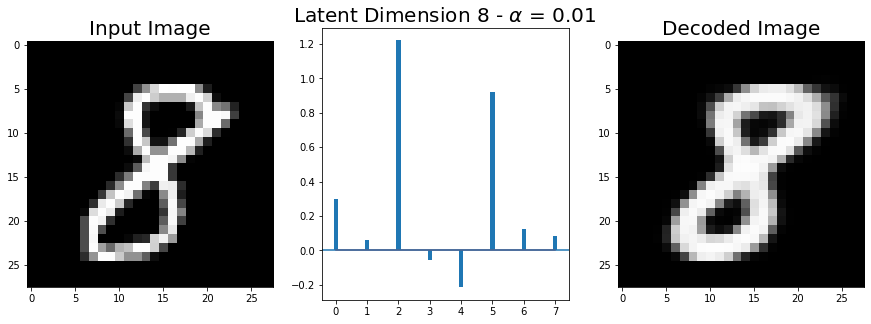

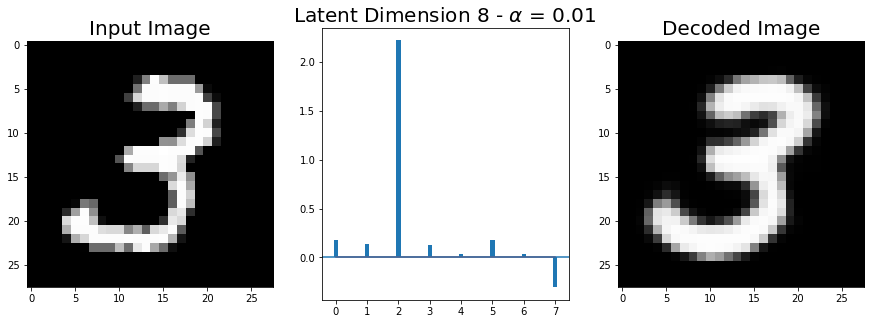

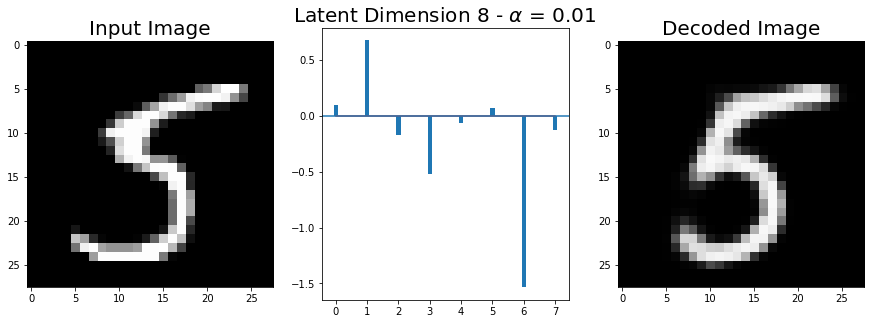

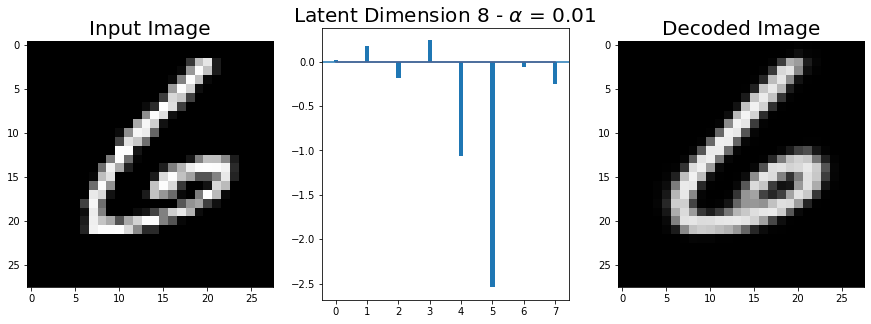

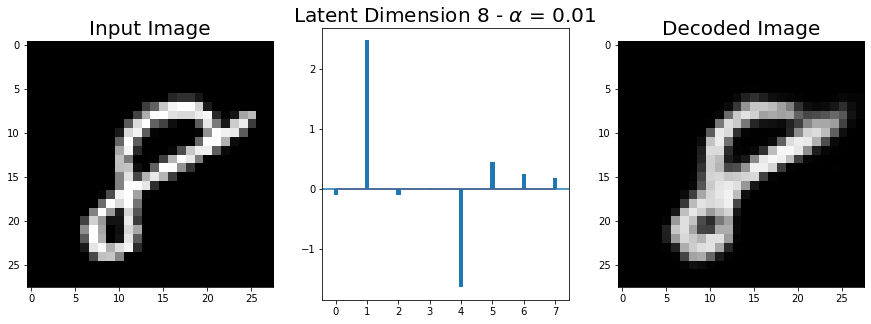

In [28]:
for i in range(data.shape[0]):
  plot_latent(data[i:i+1], z_batch[i:i+1])
  im = Image.open('sc_result.png')
  display(im)

In [0]:
def test_latent(x0, x1, x2, x3, x4, x5, x6, x7):
  fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
  ax0.set_ylim([-3, 3])
  z = torch.tensor([x0, x1, x2, x3, x4, x5, x6, x7], dtype=torch.float32).view(1, 8)
  ax0.bar(np.arange(z.shape[1]), height=z.cpu().detach().numpy()[0], width=1/7, align='center')
  #ax0.stem(np.arange(z.shape[1]), z.cpu().detach().numpy()[0], markerfmt=' ', use_line_collection=True)
  ax0.scatter(np.arange(z.shape[1]), z.detach().numpy()[0], color='red')
  #ax0.axhline(y=0)
  ax0.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % (z.shape[1], alpha), fontsize=20)
    
  z = z.cuda()
  img = g(z)
  img = torchvision.utils.make_grid(img.view(1,channel_im,dim_im,dim_im)).cpu().detach().numpy()
  ax1.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
  ax1.set_title('Decoded Image', fontsize=20)
#  plt.subplots_adjust(hspace=0.5)

In [36]:
interactive_plot = interactive(test_latent, x0=(-3.0, 3.0, 0.5), x1=(-3.0, 3.0, 0.5), x2=(-3.0, 3.0, 0.5), x3=(-3.0, 3.0, 0.5), x4=(-3.0, 3.0, 0.5), x5=(-3.0, 3.0, 0.5), x6=(-3.0, 3.0, 0.5), x7=(-3.0, 3.0, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=0.0, description='x0', max=3.0, min=-3.0, step=0.5), FloatSlider(value…

In [0]:
def interential_step(data, z):
  for j in range(l_step):
    if z.grad is not None:
      z.grad.zero_()

    generated = g(z) # Get generated result

    loss = loss_function(data, generated, sigma, s1, s2, alpha, z) # Calculate Loss
    loss.backward() # Back propagation

    u = torch.FloatTensor(z.shape[0], z.shape[1]).normal_(0, 1).cuda() # Sample gaussian noise and to GPU
    z = z - (lang_sigma ** 2) / 2 * (z.grad - der_z(z, s1, s2, alpha))  + lang_sigma * u # Gradient descent for latent variable Z

    z = z.detach().requires_grad_() # Free latent variable from computational graph, to make it leaf node

  return z